<a href="https://colab.research.google.com/github/abramed/RREA/blob/master/CIKM/RREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/abramed/RREA.git

fatal: destination path 'RREA' already exists and is not an empty directory.


In [4]:
%cd /content/RREA/CIKM

/content/RREA/CIKM


In [5]:

import tensorflow.compat.v1 as tf

config = tf.ConfigProto()

config.gpu_options.allow_growth=True  
sess = tf.Session(config=config)  

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import keras
from tqdm import *
import numpy as np
from utils import *
from CSLS import *
import keras.backend as K
from keras.layers import *
from layer import NR_GraphAttention

''' os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) '''

#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True  
#sess = tf.Session(config=config)  

' os.environ["CUDA_VISIBLE_DEVICES"] = "0"\nos.environ["TF_CPP_MIN_LOG_LEVEL"]="2"\ntf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) '

In [7]:
lang = 'zh'
train_pair,dev_pair,adj_matrix,r_index,r_val,adj_features,rel_features = load_data('data/%s_en/'%lang,train_ratio=0.30)
adj_matrix = np.stack(adj_matrix.nonzero(),axis = 1)
rel_matrix,rel_val = np.stack(rel_features.nonzero(),axis = 1),rel_features.data
ent_matrix,ent_val = np.stack(adj_features.nonzero(),axis = 1),adj_features.data


train_pair.shape,dev_pair.shape,adj_matrix.shape,r_index.shape,r_val.shape,adj_features.shape,rel_features.shape

38960 3025


((4500, 2),
 (10500, 2),
 (259545, 2),
 (331112, 2),
 (331112,),
 (38960, 38960),
 (38960, 6050))

In [8]:
node_size = adj_features.shape[0]
rel_size = rel_features.shape[1]
triple_size = len(adj_matrix)
batch_size = node_size


class TokenEmbedding(keras.layers.Embedding):
    """Embedding layer with weights returned."""

    def compute_output_shape(self, input_shape):
        return self.input_dim, self.output_dim

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs):
        return self.embeddings
    
def get_embedding():
    inputs = [adj_matrix,r_index,r_val,rel_matrix,ent_matrix]
    inputs = [np.expand_dims(item,axis=0) for item in inputs]
    return get_emb.predict_on_batch(inputs)

def test(wrank = None):
    vec = get_embedding()
    return  get_hits(vec,dev_pair,wrank=wrank)

def CSLS_test(thread_number = 16, csls=10,accurate = True):
    vec = get_embedding()
    Lvec = np.array([vec[e1] for e1, e2 in dev_pair])
    Rvec = np.array([vec[e2] for e1, e2 in dev_pair])
    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)
    eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], thread_number, csls=csls, accurate=accurate)
    return None

def get_train_set(batch_size = batch_size):
    negative_ratio =  batch_size // len(train_pair) + 1
    train_set = np.reshape(np.repeat(np.expand_dims(train_pair,axis=0),axis=0,repeats=negative_ratio),newshape=(-1,2))
    np.random.shuffle(train_set); train_set = train_set[:batch_size]
    train_set = np.concatenate([train_set,np.random.randint(0,node_size,train_set.shape)],axis = -1)
    return train_set

def get_trgat(node_size,rel_size,node_hidden,rel_hidden,triple_size,n_attn_heads = 2,dropout_rate = 0,gamma = 3,lr = 0.005,depth = 2):
    adj_input = Input(shape=(None,2))
    index_input = Input(shape=(None,2),dtype='int64')
    val_input = Input(shape = (None,))
    rel_adj = Input(shape=(None,2))
    ent_adj = Input(shape=(None,2))
    
    ent_emb = TokenEmbedding(node_size,node_hidden,trainable = True)(val_input) 
    rel_emb = TokenEmbedding(rel_size,node_hidden,trainable = True)(val_input)
    
    def avg(tensor,size):
        adj = K.cast(K.squeeze(tensor[0],axis = 0),dtype = "int64")   
        adj = tf.SparseTensor(indices=adj, values=tf.ones_like(adj[:,0],dtype = 'float32'), dense_shape=(node_size,size)) 
        adj = tf.compat.v1.sparse_softmax(adj) 
        return tf.compat.v1.sparse_tensor_dense_matmul(adj,tensor[1])
    
    opt = [rel_emb,adj_input,index_input,val_input]
    ent_feature = Lambda(avg,arguments={'size':node_size})([ent_adj,ent_emb])
    rel_feature = Lambda(avg,arguments={'size':rel_size})([rel_adj,rel_emb])
    
    encoder = NR_GraphAttention(node_size,activation="relu",
                                       rel_size = rel_size,
                                       depth = depth,
                                       attn_heads=n_attn_heads,
                                       triple_size = triple_size,
                                       attn_heads_reduction='average',   
                                       dropout_rate=dropout_rate)
    
    out_feature = Concatenate(-1)([encoder([ent_feature]+opt),encoder([rel_feature]+opt)])
    out_feature = Dropout(dropout_rate)(out_feature)
    
    alignment_input = Input(shape=(None,4))
    find = Lambda(lambda x:K.gather(reference=x[0],indices=K.cast(K.squeeze(x[1],axis=0), 'int32')))([out_feature,alignment_input])
    
    def align_loss(tensor):
        def _cosine(x):
            dot1 = K.batch_dot(x[0], x[1], axes=1)
            dot2 = K.batch_dot(x[0], x[0], axes=1)
            dot3 = K.batch_dot(x[1], x[1], axes=1)
            max_ = K.maximum(K.sqrt(dot2 * dot3), K.epsilon())
            return dot1 / max_
        
        def l1(ll,rr):
            return K.sum(K.abs(ll-rr),axis=-1,keepdims=True)
        
        def l2(ll,rr):
            return K.sum(K.square(ll-rr),axis=-1,keepdims=True)
        
        l,r,fl,fr = [tensor[:,0,:],tensor[:,1,:],tensor[:,2 ,:],tensor[:,3,:]]
        loss = K.relu(gamma + l1(l,r) - l1(l,fr)) + K.relu(gamma + l1(l,r) - l1(fl,r))
        return tf.reduce_sum(loss,keepdims=True) / (batch_size)
    
    loss = Lambda(align_loss)(find)
    
    inputs = [adj_input,index_input,val_input,rel_adj,ent_adj]
    train_model = keras.Model(inputs = inputs + [alignment_input],outputs = loss)
    train_model.compile(loss=lambda y_true,y_pred: y_pred,optimizer=keras.optimizers.RMSprop(lr))
    
    feature_model = keras.Model(inputs = inputs,outputs = out_feature)
    return train_model,feature_model

In [9]:
model,get_emb = get_trgat(dropout_rate=0.30,node_size=node_size,rel_size=rel_size,n_attn_heads = 1,depth=2,gamma =3,node_hidden=100,rel_hidden = 100,triple_size = triple_size)
model.summary(); initial_weights = model.get_weights()

get_emb

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 token_embedding (TokenEmbeddin  (38960, 100)        3896000     ['input_3[0][0]']                
 g)                                                                                               
                                                                                                  
 token_embedding_1 (TokenEmbedd  (6050, 100)         605000      ['input_3[0][0]']            

In [11]:
rest_set_1 = [e1 for e1, e2 in dev_pair]
rest_set_2 = [e2 for e1, e2 in dev_pair]
np.random.shuffle(rest_set_1)
np.random.shuffle(rest_set_2)

epoch = 1200
for turn in range(2):
    print("iteration %d start."%turn)
    for i in trange(epoch):
        train_set = get_train_set()
        inputs = [adj_matrix,r_index,r_val,rel_matrix,ent_matrix,train_set]
        inputs = [np.expand_dims(item,axis=0) for item in inputs]
        model.train_on_batch(inputs,np.zeros((1,1)))
        if i%300 == 299:
            CSLS_test()
       

    new_pair = []
    vec = get_embedding()
    Lvec = np.array([vec[e] for e in rest_set_1])
    Rvec = np.array([vec[e] for e in rest_set_2])
    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)
    A,_ = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], 16,10,False,False)
    B,_= eval_alignment_by_sim_mat(Rvec, Lvec,[1, 5, 10], 16,10,True,False)
    A = sorted(list(A)); B = sorted(list(B))
    for a,b in A:
        if  B[b][1] == a:
            new_pair.append([rest_set_1[a],rest_set_2[b]])
    print("generate new semi-pairs: %d." % len(new_pair))
    
    train_pair = np.concatenate([train_pair,np.array(new_pair)],axis = 0)
    for e1,e2 in new_pair:
        if e1 in rest_set_1:
            rest_set_1.remove(e1) 
        
    for e1,e2 in new_pair:
        if e2 in rest_set_2:
            rest_set_2.remove(e2) 
   
    

iteration 0 start.


  0%|          | 0/1200 [00:00<?, ?it/s]WARNING:tensorflow:
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'token_embedding_1/embeddings:0' shape=(6050, 100) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'token_embedding/embeddings:0' shape=(38960, 100) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.c

KeyboardInterrupt: ignored

In [10]:
model.save('model_weights.tf')

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'token_embedding_1/embeddings:0' shape=(6050, 100) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'token_embedding/embeddings:0' shape=(38960, 100) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [10]:
get_emb.save('get_emb.tf')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
get_emb.load_weights("/content/drive/MyDrive/research project/code source/rrea/weight/get_emb.tf")

In [14]:
rest_set_1 = [e1 for e1, e2 in dev_pair]
rest_set_2 = [e2 for e1, e2 in dev_pair]
np.random.shuffle(rest_set_1)
np.random.shuffle(rest_set_2)

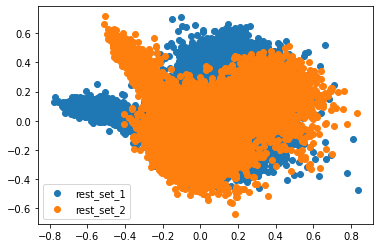

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get embeddings
vec = get_embedding()
Lvec = np.array([vec[e] for e in rest_set_1])
Rvec = np.array([vec[e] for e in rest_set_2])

# apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
Lvec_pca = pca.fit_transform(Lvec)
Rvec_pca = pca.fit_transform(Rvec)

# plot embeddings
fig, ax = plt.subplots()
ax.scatter(Lvec_pca[:, 0], Lvec_pca[:, 1], label='rest_set_1')
ax.scatter(Rvec_pca[:, 0], Rvec_pca[:, 1], label='rest_set_2')
ax.legend()
plt.show()

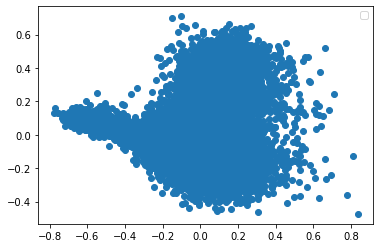

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get embeddings
vec = get_embedding()

# apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
vec_pca = pca.fit_transform(Lvec)
# plot embeddings
fig, ax = plt.subplots()
ax.scatter(vec_pca[:, 0], vec_pca[:, 1])
ax.legend()
plt.show()

In [19]:
import numpy as np

batch_size = 100
vec_batches = np.array_split(vec, len(vec) // batch_size)


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

threshold = 0.8
similar_nodes = []

for vec_batch in vec_batches:
    similarities = cosine_similarity(vec_batch)
    for i in range(len(similarities)):
        for j in range(i+1, len(similarities)):
            if similarities[i][j] > threshold:
                similar_nodes.append((i, j))

In [22]:
similar_nodes_dict = {}

for node_pair in similar_nodes:
    node1, node2 = node_pair
    if node1 not in similar_nodes_dict:
        similar_nodes_dict[node1] = set()
    if node2 not in similar_nodes_dict:
        similar_nodes_dict[node2] = set()
    similar_nodes_dict[node1].add(node2)
    similar_nodes_dict[node2].add(node1)

In [28]:
len(similar_nodes_dict.keys())
len(similar_nodes)

930

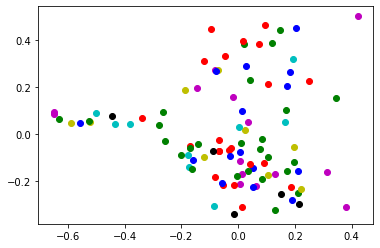

In [26]:
import matplotlib.pyplot as plt


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # You can customize the colors

fig, ax = plt.subplots()

for i, node in enumerate(similar_nodes_dict.keys()):
    embedding = vec_pca[node]
    group = -1  # Assign a default group number
    for j, (group_nodes, nodes_set) in enumerate(similar_nodes_dict.items()):
        if node in nodes_set:
            group = j
            break
    color = colors[group % len(colors)]  # Choose a color for the group
    ax.scatter(embedding[0], embedding[1], color=color)

plt.show()